### Data cleansing

To start, let’s import the librabies and read our data into a Pandas DataFrame and display the first five rows of data:

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Hospital Emergency Room Data.csv")
df.head()

,Patient Id,Patient Admission Date,Patient First Inital,Patient Last Name,Patient Gender,Patient Age,Patient Race,Department Referral,Patient Admission Flag,Patient Satisfaction Score,Patient Waittime,Patient Admission Flag.1
0,145-39-5406,20-03-2024 08:47,H,Glasspool,M,69,White,None,False,10.0,39,False
1,316-34-3057,15-06-2024 11:29,X,Methuen,M,4,Native American/Alaska Native,None,True,NaN,27,True
2,897-46-3852,20-06-2024 09:13,P,Schubuser,F,56,African American,General Practice,True,9.0,55,True
3,358-31-9711,04-02-2024 22:34,U,Titcombe,F,24,Native American/Alaska Native,General Practice,True,8.0,31,True
4,289-26-0537,04-09-2024 17:48,Y,Gionettitti,Male,5,African American,Orthopedics,False,NaN,10,False


Next, we're gonna see the information about this dataset and do some cleaning job based on this.

In [3]:
# check out data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9216 entries, 0 to 9215
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient Id                  9216 non-null   object 
 1   Patient Admission Date      9216 non-null   object 
 2   Patient First Inital        9216 non-null   object 
 3   Patient Last Name           9216 non-null   object 
 4   Patient Gender              9216 non-null   object 
 5   Patient Age                 9216 non-null   int64  
 6   Patient Race                9216 non-null   object 
 7   Department Referral         9216 non-null   object 
 8   Patient Admission Flag      9216 non-null   bool   
 9   Patient Satisfaction Score  2517 non-null   float64
 10  Patient Waittime            9216 non-null   int64  
 11  Patient Admission Flag.1    9216 non-null   bool   
dtypes: bool(2), float64(1), int64(2), object(7)
memory usage: 738.1+ KB


In [4]:
# check out the null values
df.isnull().sum()

Patient Id                       0
Patient Admission Date           0
Patient First Inital             0
Patient Last Name                0
Patient Gender                   0
Patient Age                      0
Patient Race                     0
Department Referral              0
Patient Admission Flag           0
Patient Satisfaction Score    6699
Patient Waittime                 0
Patient Admission Flag.1         0
dtype: int64

In [5]:
# print the percentage that null values accounts for 
percent = df["Patient Satisfaction Score"].isnull().sum()/len(df)
print(f'The percentage of null values in Patient Satisfaction Score is: { percent*100:.2f}%')

The percentage of null values in Patient Satisfaction Score is: 72.69%


Since the percentage of null value in `Patient Satisfaction Score` column is 72.69%, I decide to use mean value to impute the missing values in this case.

In [6]:
df['Patient Satisfaction Score'].fillna(df['Patient Satisfaction Score'].mean(),inplace=True)

Now, let's see if some duplicate values in the dataset.

In [7]:
df.duplicated().sum()

0

Check out the format in dataset.

In [8]:
# Check if all string columns have consistent formatting
string_columns = df.select_dtypes(include=['object']).columns
for col in string_columns:
    # Check if all strings are lowercase (as an example)
    if not df[col].apply(lambda x: isinstance(x, str) and x.islower()).all():
        print(f"Column '{col}' contains inconsistent string formatting.")
    else:
        print(f"Column '{col}' has consistent string formatting.")


Column 'Patient Id' contains inconsistent string formatting.
Column 'Patient Admission Date' contains inconsistent string formatting.
Column 'Patient First Inital' contains inconsistent string formatting.
Column 'Patient Last Name' contains inconsistent string formatting.
Column 'Patient Gender' contains inconsistent string formatting.
Column 'Patient Race' contains inconsistent string formatting.
Column 'Department Referral' contains inconsistent string formatting.


In [9]:
# covert Petient admission date to datetime type
df['Patient Admission Date'] = pd.to_datetime(df['Patient Admission Date'],errors='coerce')

In [10]:
# Mapping dictionary to replace both short codes and full names
mapping = {'M': 'Male', 'F': 'Female', 'Male': 'Male', 'Female': 'Female'}

# Apply the mapping and update the 'Patient Gender' column
df['Patient Gender'] = df['Patient Gender'].map(mapping)

# Verify the changes
print(df['Patient Gender'].value_counts())

Male      4729
Female    4487
Name: Patient Gender, dtype: int64


In [11]:
df['Patient Race'].value_counts()

White                            2571
African American                 1951
Two or More Races                1557
Asian                            1060
Declined to Identify             1030
Pacific Islander                  549
Native American/Alaska Native     498
Name: Patient Race, dtype: int64

In [12]:
# noted that the None value accounts for the biggest percentage in this column 
df['Department Referral'].value_counts()

None                5400
General Practice    1840
Orthopedics          995
Physiotherapy        276
Cardiology           248
Neurology            193
Gastroenterology     178
Renal                 86
Name: Department Referral, dtype: int64

In [13]:
# impute the None value in department referral using percentage of each values

# Replace 'None' string with NaN (missing values)
df['Department Referral'] = df['Department Referral'].replace('None', np.nan)


#Calculate the distribution of the non-missing values
distribution = df['Department Referral'].value_counts(normalize=True)

# Impute missing values by sampling from this distribution
missing_count = df['Department Referral'].isna().sum()

# Sample values based on the calculated distribution
samples = np.random.choice(distribution.index, size=missing_count, p=distribution.values)

#  Fill the missing values with the sampled values
df.loc[df['Department Referral'].isna(), 'Department Referral'] = samples

# Verify the result
print(df['Department Referral'].value_counts())

General Practice    4420
Orthopedics         2393
Physiotherapy        675
Cardiology           596
Neurology            484
Gastroenterology     435
Renal                213
Name: Department Referral, dtype: int64


### Data visualization--Descriptive analysis

#### Categorical varaibles

In this part, we can see basic distribution of the information like `Patient Wait Time` and other columns, the aim is to view the first look of the data information

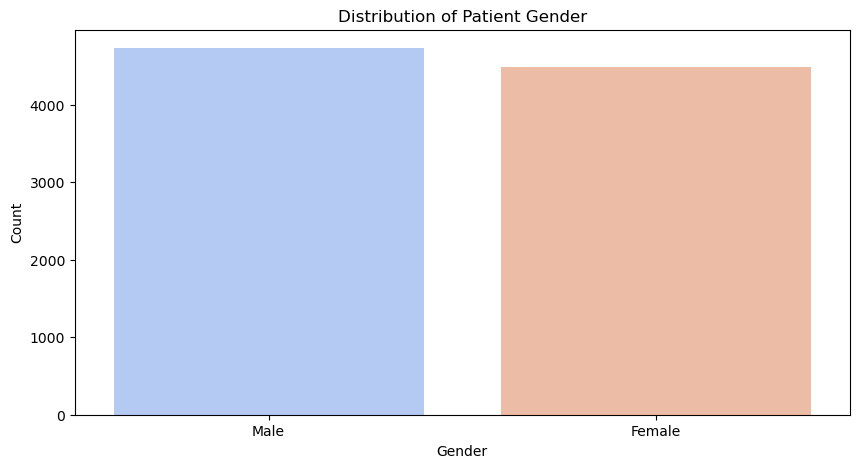

In [14]:
# show the distribution of patient gendetr 
plt.figure(figsize=(10, 5))
sns.countplot(x='Patient Gender', data=df, palette='coolwarm')
plt.title('Distribution of Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

From this bar chart, we can see that the male patient is a little bit more than female patient.

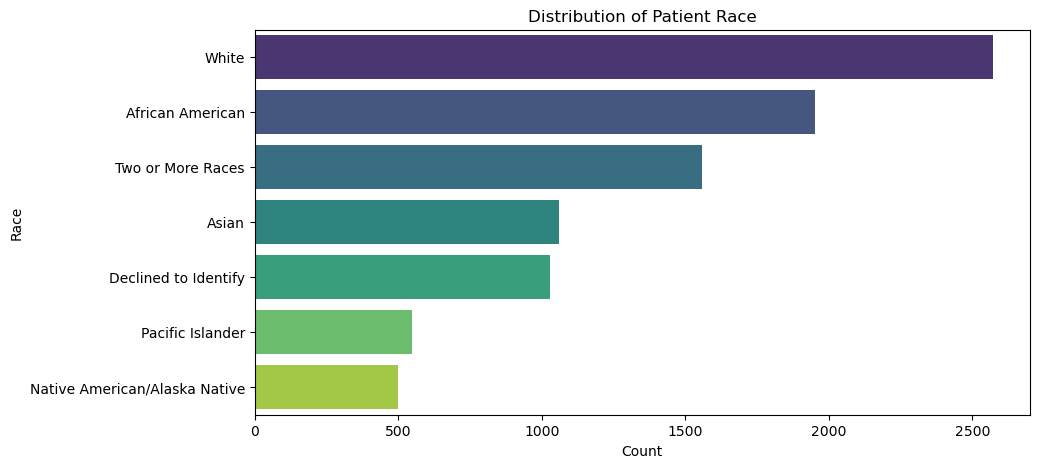

In [15]:
# Calculate the count of each unique value in 'Patient Race'
order = df['Patient Race'].value_counts().index

# Create the countplot, using the 'order' to sort the bars
plt.figure(figsize=(10, 5))
sns.countplot(y='Patient Race', data=df, palette='viridis', order=order)

# Add title and labels
plt.title('Distribution of Patient Race')
plt.xlabel('Count')
plt.ylabel('Race')

# Show the plot
plt.show()

The chart shows that "White" patients are the most represented, followed by "African American," while other racial groups like "Asian," "Pacific Islander," and "Native American/Alaska Native" have lower counts. This indicates disparities in representation within the patient population. Understanding this distribution is essential for addressing healthcare equity and ensuring all groups receive adequate care.

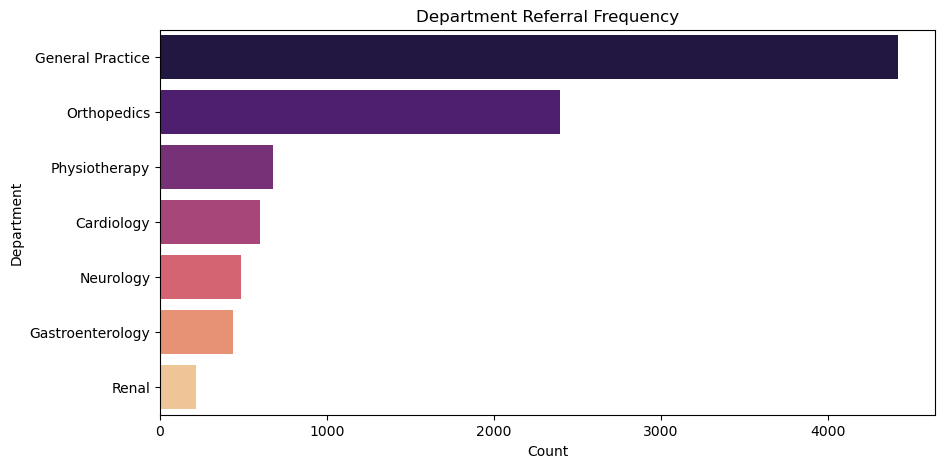

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(y='Department Referral', data=df, palette='magma', order=df['Department Referral'].value_counts().index)
plt.title('Department Referral Frequency')
plt.xlabel('Count')
plt.ylabel('Department')
plt.show()


The above bar chart shows the frequency of referrals to various medical departments. The departments listed include General Practice, Orthopedics, Physiotherapy, Cardiology, Neurology, Gastroenterology, and Renal. The x-axis represents the count of referrals, ranging from 0 to 4000, allowing for a comparison of referral volumes across different departments. This visualization helps in understanding which departments receive the most referrals, indicating areas of higher patient need or specialization within the healthcare system.

#### Numerical variables

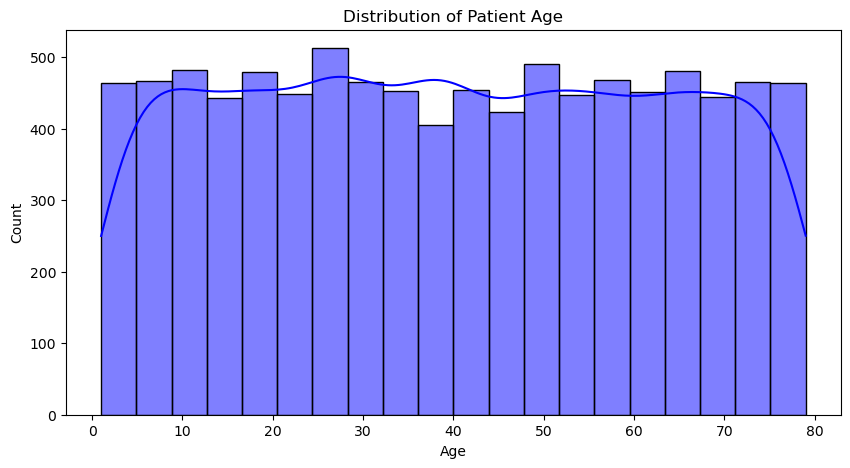

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Patient Age'], bins=20, kde=True, color='blue')
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


From this histogram, we can see that the patient age is almost evenly distributed.

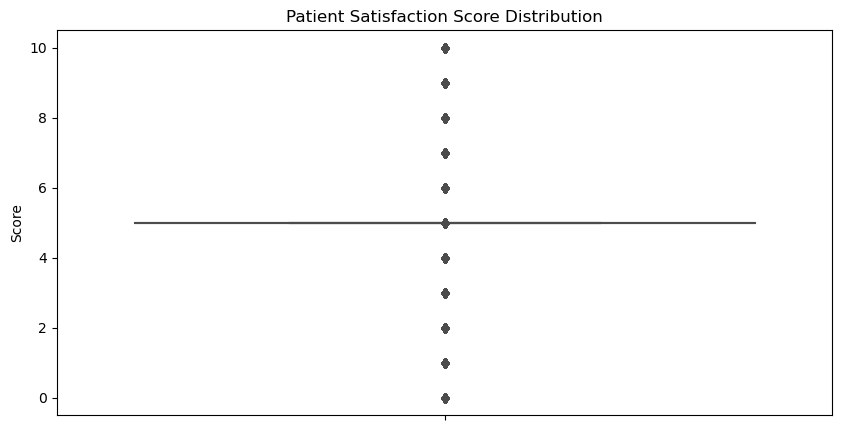

In [18]:
plt.figure(figsize=(10, 5))
sns.boxplot(y=df['Patient Satisfaction Score'], color='red')
plt.title('Patient Satisfaction Score Distribution')
plt.ylabel('Score')
plt.show()


This scatter plot, titled "Patient Satisfaction Score Distribution," displays individual patient satisfaction scores ranging from 0 to 10, with a horizontal line at a score of 4 indicating average. The scores are evenly distributed above and below this line, with no clear clustering, suggesting a wide range of patient experiences. The lack of a trend or pattern indicates that patient satisfaction varies significantly without a dominant score.

#### Bivariate analysis

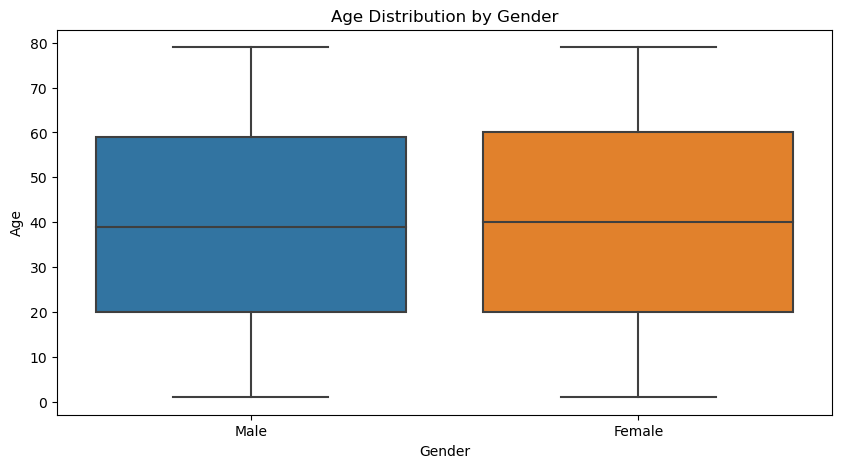

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Patient Gender', y='Patient Age', data=df)
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()


The box plot titled "Age Distribution by Gender" compares the age distributions of male and female patients. Both groups exhibit a median age of approximately 45, with the middle 50% of ages (interquartile range) spanning from about 20 to 60, and the full age range extending from around 0 to 80, with no outliers present. This similarity in medians, interquartile ranges, and overall ranges indicates that the age distribution is consistent across genders in this dataset.

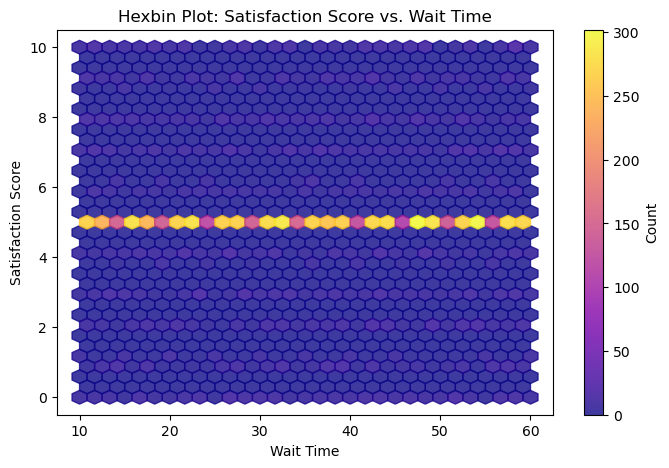

In [20]:
plt.figure(figsize=(8, 5))
plt.hexbin(df['Patient Waittime'], df['Patient Satisfaction Score'], gridsize=30, cmap='plasma', alpha=0.8)
plt.colorbar(label='Count')
plt.title('Hexbin Plot: Satisfaction Score vs. Wait Time')
plt.xlabel('Wait Time')
plt.ylabel('Satisfaction Score')
plt.show()


The hexbin plot shows that most patient experiences cluster around moderate satisfaction scores (4 to 6) and wait time (20 to 40), with the highest density of data points in these ranges. Fewer instances occur at the extremes, suggesting that extreme satisfaction or wait times are rare. This indicates a general trend toward average patient experiences.

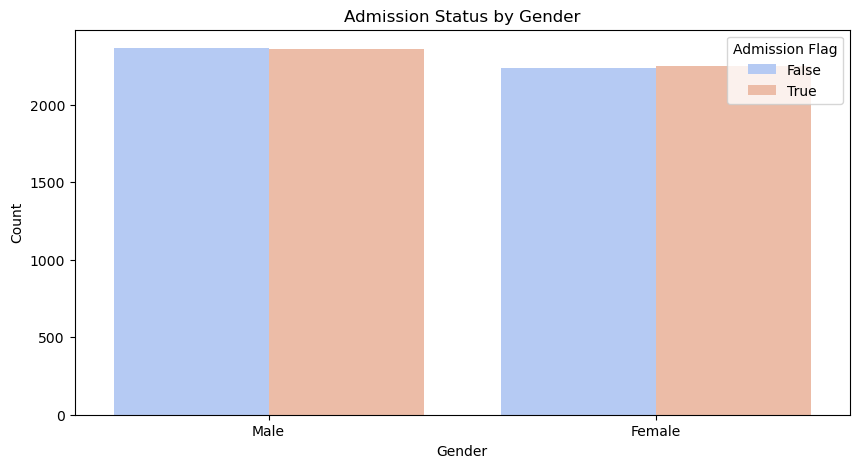

In [21]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Patient Gender', hue='Patient Admission Flag', data=df, palette='coolwarm')
plt.title('Admission Status by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Admission Flag')
plt.show()


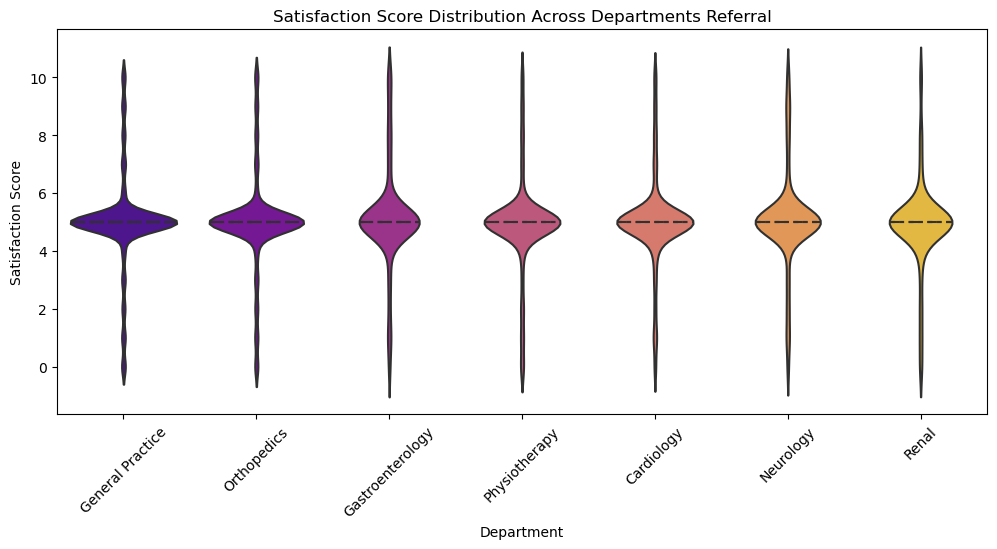

In [25]:
plt.figure(figsize=(12, 5))
sns.violinplot(x='Department Referral', y='Patient Satisfaction Score', data=df, palette='plasma', inner='quartile')
plt.xticks(rotation=45)
plt.title('Satisfaction Score Distribution Across Departments Referral')
plt.xlabel('Department')
plt.ylabel('Satisfaction Score')
plt.show()



The violin plot shows satisfaction scores for various medical departments such as General Practice, Orthopedics, Gastroenterology, Physiotherapy, Cardiology, Neurology, and Renal. The satisfaction scores range from 0 to 10. This visualization helps identify which departments are performing well in terms of patient satisfaction and which may need improvement.

#### Time series analysis

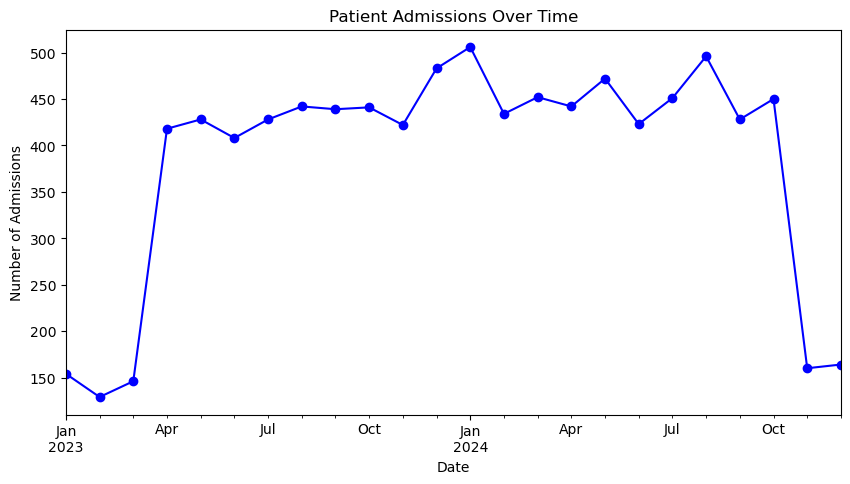

In [ ]:
plt.figure(figsize=(10, 5))
df.resample('M').size().plot(marker='o', color='blue')
plt.title('Patient Admissions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Admissions')
plt.show()


The line graph illustrates patient admissions over a two-year period, revealing significant fluctuations with a notable peak around January 2024 and a sharp decline towards October 2024. Admissions generally trend upward from early 2023 until mid-2024, reaching approximately 500, before dropping to around 150 by late 2024. The data suggests seasonal or event-driven variations in patient intake, with potential implications for healthcare resource planning.

### Diagnostic analysis -- Pareto analysis

Pareto analysis is a decision-making method widely used by analytics teams across disparate industries. It attributes the majority of a given problem to a top percentage of cases. Specifically, it’s based on the idea that 20 percent of causes result in 80 percent of problems. In practice, the 80/20 split is a guideline that generally suggests that a small minority of causes are responsible for the majority of problems. As such, the exact values don't have to precisely align with the 80/20 rule as the split in practice may be 75/25, 90/10, or 85/15. The heuristic is meant to be a guide for distinguishing the vital few factors that are pertinent to a problem from the insignificant many that aren’t. 

Extremely versatile, Pareto analysis can identify impactful subsets of data in a wide variety of industries including retail, information technology, marketing, and healthcare. 


There are steps of Pareto Analysis:
- Define your problem and the associated causes. 
- Calculate the frequency of each cause within a problem. 
- Sort the frequencies from highest to lowest.
- Plot a bar chart of the frequencies. 
- Calculate the cumulative sum of the unit of measure through each cause. For example, calculate the total cumulative percentage of department referral.
- Create a line plot of the cumulative percentage. 
- Label the left side of the y-axis with “Frequency” and the right side with “Cumulative Percentage.”
- Label the x-axis with the “Problem Causes” for the prescription problem label “Department Referral.” 
- Title the plot “Pareto Chart of Diagnosis” 
- Analyze Pareto Chart – Inspect the top few causes that contribute to most of the problems. 

Next, let’s filter our data to only include readmitted patients:

In [26]:
admitted = df[df['Patient Admission Flag'] == True]

We can then use this filtered DataFrame to count the number of times a cause appears in the admitted patient data:

In [27]:
cause_counts = admitted['Department Referral'].value_counts()
cause_counts

General Practice    2198
Orthopedics         1198
Physiotherapy        344
Cardiology           301
Neurology            240
Gastroenterology     219
Renal                112
Name: Department Referral, dtype: int64

Next, we can calculate the cumulative sum of readamission_cause counts and divide by the total count of admissions to get the cumulative percentage in cause counts:

In [34]:
cumulative_percent = (cause_counts.cumsum() / cause_counts.sum()) * 100  # multiply by 100 for percentage

Next, to be able to generate our Pareto chart, we need to define a Matplotlib subplot object, which we will call ax1, and we can label our x and y axes, format the values to be frequency, color to be cyan for the y-ticks on the y-axis, and format the plot legend to be located on the upper left of the chart, next, we will create a secondary y-axis, which is where the values for the cumulative percentages will reside.

This step will enable us to overlay two plots, a bar chart for frequencies and a line plot for cumulative percentages. Next, we generate a line plot of our cumulative percentages, and format the y-axis label to be cumulative percentage, y-ticks to be red, and legend to be on the upper right.

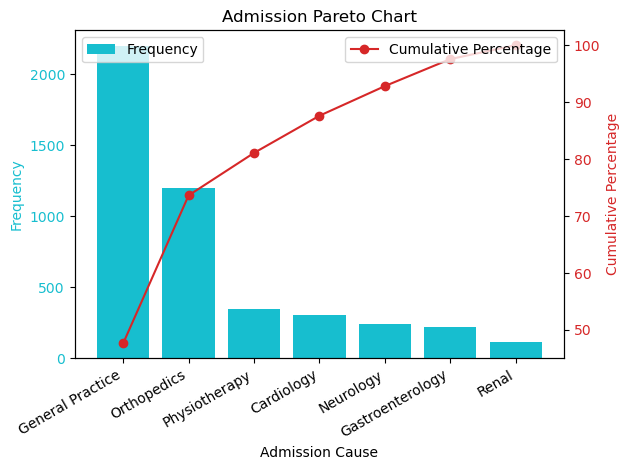

In [ ]:
_, ax1 = plt.subplots()
ax1.bar(cause_counts.index, cause_counts.values, color='tab:cyan', label='Frequency')

# Correcting the typo
ax1.set_xlabel('Admission Cause')
ax1.set_ylabel('Frequency', color='tab:cyan')

ax1.tick_params(axis='y', labelcolor='tab:cyan')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(cause_counts.index, cumulative_percent , zorder=2, color='tab:red', label='Cumulative Percentage', marker='o')
ax2.set_ylabel('Cumulative Percentage', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')
plt.title('Admission Pareto Chart')
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.show()


The Pareto chart reveals that a small number of admission causes account for the majority of hospital admissions. General Practice and Orthopedics dominate, comprising approximately 70% of all admissions combined. Physiotherapy, Cardiology, Neurology, and Gastroenterology form the next significant group, while Renal admissions are minimal. This 80/20 pattern (where 20% of causes account for 80% of admissions) suggests strategic opportunities for healthcare planning. By focusing on the most frequent admission causes, hospitals can optimize resource allocation, staffing, and preventive care initiatives to address the majority of patient needs efficiently.

### Modeling -- Predictive analysis 

In this modeling part, we will do the classification model to predict the `Patient Addimission Flag`, which is a boolean column only has value True and Flase

First, we drop some columns that are unnecessary.

In [56]:
# Drop unnecessary columns (e.g., patient name, ID)
df = df.drop(columns=['Patient Id', 'Patient First Inital', 'Patient Last Name','Patient Admission Flag.1'])

Next, we deal with the categorical columns and encode them.

In [ ]:
# Define categorical columns
categorical_cols = ['Patient Gender', 'Patient Age', 'Patient Race', 'Department Referral']

# Apply Label Encoding
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])



Next, build the correlation heatmap to see variables related to each other.

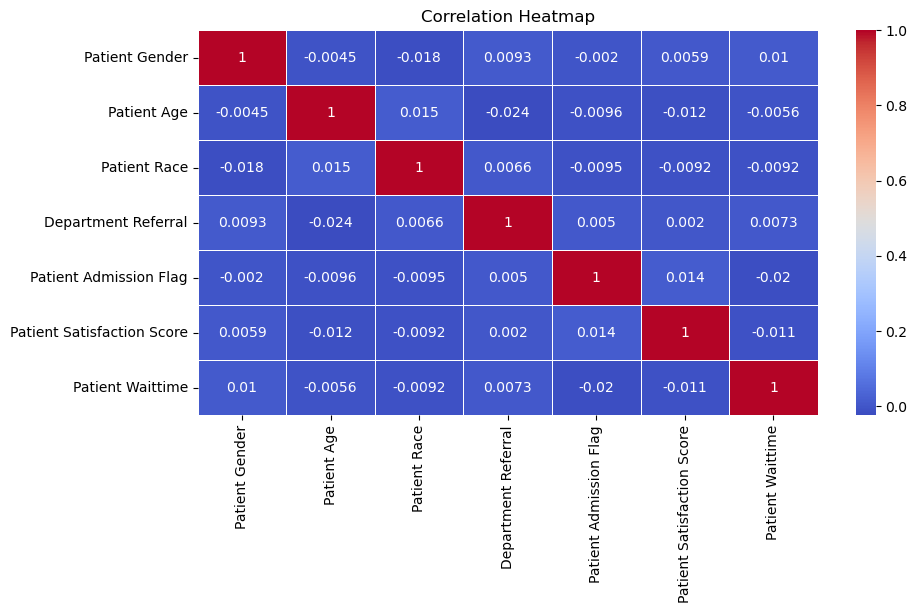

In [60]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


Next, build the target variable and feature varaibles.

In [ ]:
# Features and Target
X = df[['Patient Gender', 'Patient Age', 'Patient Race', 'Department Referral', 
        'Patient Satisfaction Score', 'Patient Waittime']]
y = df['Patient Admission Flag']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Build the several models to compare the results.

In [ ]:
def evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42),
        'SVM': SVC(random_state=42),
        'KNN': KNeighborsClassifier(),
        'MLP': MLPClassifier(random_state=42),
        'Naive Bayes': GaussianNB()
    }
    
    results = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append({'Model': name, 'Accuracy': accuracy})
    
    results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
    return results_df



In [ ]:
results_df = evaluate_models(X_train, X_test, y_train, y_test)
print(results_df)

           Model  Accuracy
5    Naive Bayes  0.503254
0  Random Forest  0.502169
2            SVM  0.495119
3            KNN  0.494035
1        XGBoost  0.484816
4            MLP  0.480477


Hypertuning models.

In [ ]:
def hypertune_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Random Forest': (RandomForestClassifier(random_state=42), {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, 30, None]
        }),
        'XGBoost': (XGBClassifier(random_state=42), {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 10]
        }),
        'SVM': (SVC(random_state=42), {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }),
        'KNN': (KNeighborsClassifier(), {
            'n_neighbors': [3, 5, 7]
        }),
        'MLP': (MLPClassifier(random_state=42), {
            'hidden_layer_sizes': [(50,), (100,), (50,50)],
            'alpha': [0.0001, 0.001, 0.01]
        }),
        'Naive Bayes': (GaussianNB(), {})  # No hyperparameters for tuning
    }
    
    results = []
    
    for name, (model, param_grid) in models.items():
        if param_grid:
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            best_model = model.fit(X_train, y_train)
            best_params = "N/A"
        
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append({'Model': name, 'Best Params': best_params, 'Accuracy': accuracy})
    
    results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
    return results_df

In [ ]:
results_df = hypertune_and_evaluate_models(X_train, X_test, y_train, y_test)
print(results_df)

           Model                                        Best Params  Accuracy
2            SVM                        {'C': 0.1, 'kernel': 'rbf'}  0.503796
5    Naive Bayes                                                N/A  0.503254
0  Random Forest             {'max_depth': 30, 'n_estimators': 200}  0.496746
3            KNN                                 {'n_neighbors': 7}  0.484816
4            MLP  {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50)}  0.483189
1        XGBoost             {'max_depth': 10, 'n_estimators': 200}  0.482104


Feature Importance

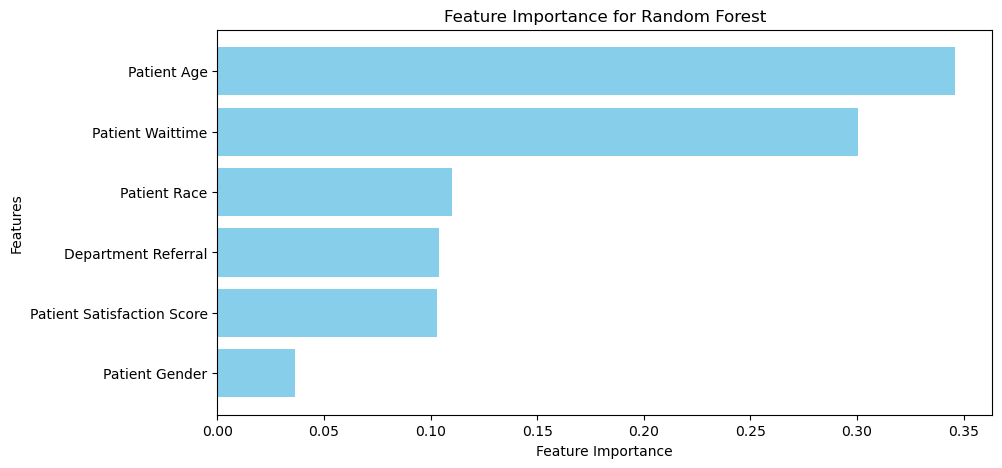

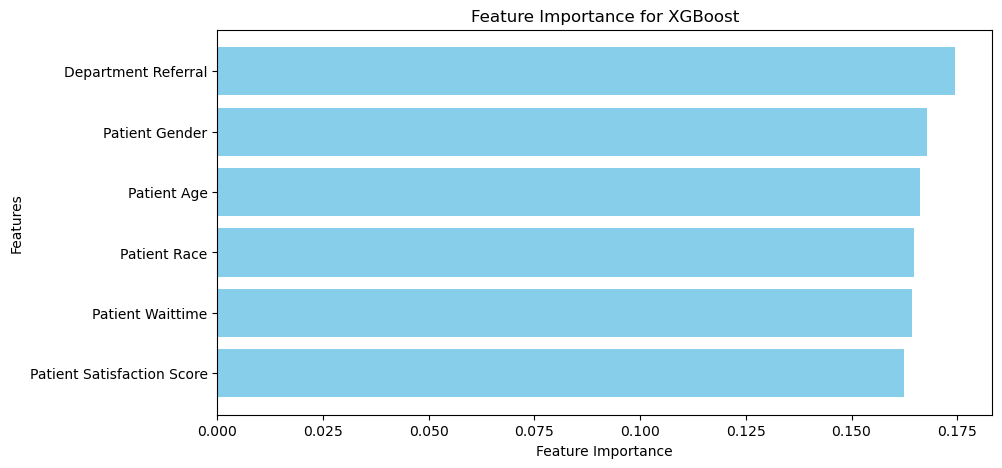

In [ ]:
def plot_feature_importance(model, feature_names, model_name, X_test, y_test):
    if hasattr(model, "feature_importances_"):  # For RF & XGBoost
        importance = model.feature_importances_
    else:  # Use permutation importance for other models
        result = permutation_importance(model, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=42, n_jobs=-1)
        importance = result.importances_mean

    sorted_idx = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(10, 5))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], color='skyblue')
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title(f"Feature Importance for {model_name}")
    plt.gca().invert_yaxis()
    plt.show()


best_rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42).fit(X_train, y_train)
plot_feature_importance(best_rf_model, X_train.columns, "Random Forest", X_test, y_test)

# Similarly, for XGBoost:
best_xgb_model = XGBClassifier(n_estimators=100, max_depth=6, random_state=42).fit(X_train, y_train)
plot_feature_importance(best_xgb_model, X_train.columns, "XGBoost", X_test, y_test)
